<a href="https://colab.research.google.com/github/denalimarsh/Deep-Learning/blob/main/linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf

# ------------- Constant tensors -------------
ones = tf.ones(shape=(2, 1))
print(ones)

zeros = tf.zeros(shape=(2, 1))
print(zeros)

# ------------- Random tensors -------------
# random values drawn from normal distribution: mean 0, standard deviation 1
rand_normal = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(rand_normal)

# random values drawn from uniform distribution: low 0, high 1
rand_uniform = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(rand_uniform)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[1.9047277]
 [2.999298 ]
 [0.734197 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.58333457]
 [0.7793139 ]
 [0.03304958]], shape=(3, 1), dtype=float32)


In [16]:
import tensorflow as tf

# ------------- TensorFlow variables -------------
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

v.assign_add(tf.ones((3, 1)))


<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 2.318819  ],
       [-0.65636855],
       [ 0.0570926 ]], dtype=float32)>


<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.318819  ],
       [0.34363145],
       [1.0570925 ]], dtype=float32)>

In [32]:
import tensorflow as tf

# ------------- Gradients -------------
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)

# gradient refers to the difference between input and output
gradient = tape.gradient(result, input_var)
print("result:", result)
print("gradient:", gradient)


# ------------- Nested gradients -------------
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


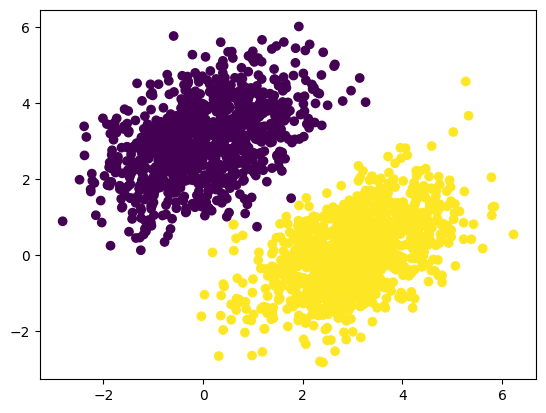

Loss at step 0: 0.4069
Loss at step 10: 0.0562
Loss at step 20: 0.0388
Loss at step 30: 0.0315
Loss at step 40: 0.0284


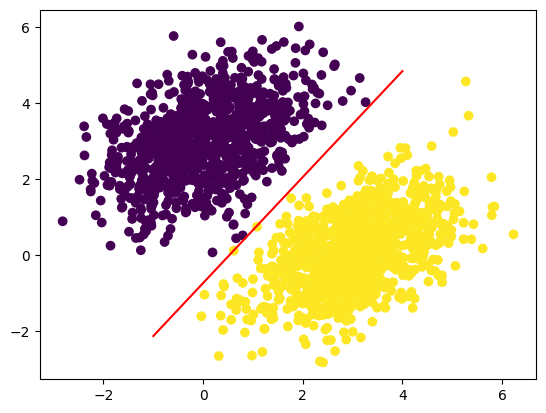

In [3]:
# ---------------------------------------------
# ------------- Linear classifier -------------
# ---------------------------------------------

import numpy as np
import tensorflow as tf

# ------------- Set up data to be classified -------------
# Data = [inputs, target labels]

# Generate two sets of 1000 random points, clustered around different coordinates
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class
)

# Both samples are arrays with shape(1000, 2), let's stack them into a single array with shape(2000, 2)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
# Stacked target labels (0 corresponds with negative samples, 1 corresponds with positive samples)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

# Plot the points
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

# ------------- Linear classifier implementation -------------
# A linear classifier is an affine transformation (prediction = W . input + b)
# It is trained to minimize the square of the difference between predictions and targets

input_dim = 2  # inputs: 2D points
output_dim = 1 # outputs: 1 score per sample (closer to 0 means predicted to be in class 0, 1 means class 1)

# W is two scalar coefficients: W = [[w1], [w2]]
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim))) # Initialized with random values
# b is one scalar coefficient: b
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,))) # Initialized with 0s

# prediction = W . input + b
# prediction = [[w1], w2]] . [x, y] + b
# prediction = (w1*x) + (w2*y) + b

# Forward pass function: returns predictions
def model(inputs):
  return tf.matmul(inputs, W) + b

# Loss function: returns loss
def square_loss(targets, predictions):
  # Tensor with same shape as targets/predictions, containing per-sample loss scores
  per_sample_losses = tf.square(targets - predictions)
  # reduce_mean averages per-sample loss scores into a single scalar loss value
  return tf.reduce_mean(per_sample_losses)

# Training step function
learning_rate = 0.1
def training_step(inputs, targets):
  # Execute forward pass inside a gradient tape scope
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(predictions, targets)

  # Retrieve the gradient of the loss with regard to the weights
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])

  # Update the weights
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)

  return loss

# Batch training loop: training over entire data instead of sub-batches
# - each training step will take longer to run since we compute forward pass/gradients for 2000 samples at once
# - each gradient update will be more effective at reducing loss on training data, since it's using all samples
# - result: fewer steps of training and should use a larger learning rate of 0.1
for step in range(41):
  loss = training_step(inputs, targets)
  if step % 10 == 0:
    print(f"Loss at step {step}: {loss:.4f}")

# Our linear model is now trained, now we can plot how it classifies the training data points
predictions = model(inputs)
# plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
# plt.show

# The plotted line can be described as (w1*x + w2*y + b > 0.5)
# In (y=a*x+b) format, the line can be written as (y = -w1/w2*x + (0.5 - b) / w2)

# Plot the classification line
x = np.linspace(-1, 4, 100) # Generate 100 regularly spaced numbers between -1 and 4 to be used to plot the line
y = -W[0] / W[1] * x + (0.5-b) / W[1] # Equation of the line
plt.plot(x, y, "-r") # Plot it as a red line
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5) # Plot our predictions on the same plot

